# Blackjack with Card Counting
#### By Ryan Porter

## Abstract


## Background
Backjack as known as Twenty-One, is a card game between one or more players and a dealer. Each player takes turns competing against the dealer, the goal is to have your cards sum be as close to 21 as possible. 
- If the player is dealt an Ace and a ten-valued card, that's a blackjack and the player wins.
- If the player's sum exceeds 21, then that's a "bust" and he looses.
- If the dealer busts and the player does not, then the player wins.
- If the player has a higher sum than the dealer without busting, then the player wins.
- If the player and dealer have the samve sum or both got Blackjack, then no one wins.

There are many different variations to the game with lots of other rules, but I wanted to keep it simple. In order to try tilting the odds in our favor, we are going to try a few different card counting strategies.   

## Import Modules

In [41]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Create Functions

In [42]:
def check_ace(hand): 
    """
    Checks if there's an ace in the hand in case total went over 21
    """
    if 'A' in hand:
        hand[hand.index('A')] = 'A.'
        return True
    else:
        return False
    
def hand_total(hand): 
    """
    Calculates sum total values from a list of strings using a dictionary
    """
    d_val = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
             '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11, 'A.': 1}
    return int(sum(d_val[i] for i in hand))


def deal_card(hand, deck, num_of_cards=1): 
    """
    Deals a card, defaulted to one card
    """
    for _ in range(num_of_cards):
        hand.append(deck.pop())
    return hand


def create_deck(num_of_decks=2): 
    """
    Creates a standard playing card deck, defaulted to one deck
    """
    deck = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']*4*num_of_decks
    random.shuffle(deck)
    return deck

## Dealer Functions

In [43]:
def dealer_turn(your_hand, dealer_hand, total, dtotal, deck, r_count, true_cnt, strategy, turn=True): 
    """
    Activates the dealer's turn if player's move was 'stay'
    """
    # Tallying wins, losses, and draws
    wins = 0
    draw = 0
    loss = 0
    
    # Looping through the moves
    while turn:
        total  = hand_total(your_hand)
        if total > 21: 
            
            # Evaluating a player's hand to see if they have an ace
            check_ace(your_hand)
            total = hand_total(your_hand)
            continue
            
        dtotal = hand_total(dealer_hand)

        # Dealing cards to the dealer if they have less than or equal to 16
        while dtotal <= 16: 
            deal_card(dealer_hand, deck)
            dtotal = hand_total(dealer_hand)
            
            # Counter
            r_count += card_counter(dealer_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
        # Checking if the dealer wins
        if dtotal == 21: 
            loss += 1
            break

        # Checking if the dealer busts
        elif dtotal > 21: 
            if check_ace(dealer_hand):
                continue
            else:
                wins += 1
                break
                
        # Comparing dealer hand to player hand
        elif 17 <= dtotal <= 21: 
            if dtotal > total:
                loss += 1
                break
            elif dtotal < total:
                wins += 1
                break
            elif dtotal == total:
                draw += 1
                break
            else:
                wins += 1
                break
    return [wins, loss, draw, r_count, true_cnt]

## Player Turn Function

In [44]:
def player_move(your_hand, limit, true_cnt, dealer_hand):
    """
    Chooses 'hit' or 'stay' depending on the limit set and count
    """
    
    dtotal = hand_total(dealer_hand[:1])

    # Meaning there are plenty of face cards left
    if true_cnt > 0:
        if hand_total(your_hand) >= limit:
            return 'stay'
        elif hand_total(your_hand) < limit:
            return 'hit'
        elif dtotal >= 10:
            return 'stay'
        
        
    # Meaning there are plenty of low cards left: < 6 value
    elif true_cnt < 0:
        if hand_total(your_hand) <= limit:
            return 'hit'
        elif hand_total(your_hand) > limit:
            return 'stay'
        elif dtotal < 10:
            return 'hit'
        
        
    # Meaning the count is neutral so play a basic strategy    
    else:
        if hand_total(your_hand) >= 17:
            return 'stay'
        elif hand_total(your_hand) < 17:
            return 'hit'

## Card Counting Strategies

The most common strategy is called Hi-Lo, the reason is that at the right end the value is +1 and on the left side it is -1. The idea is when the deck has one card left, the value of the remaining card plus the running sum of the deck will equal 0.  

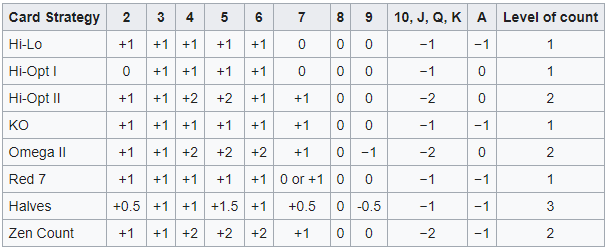

In [45]:
# Creating a simple dictionary to start the values
vals = {'2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 0, '8': 0, '9': 0, '10': -1, 'J': -1, 
        'Q': -1, 'K': -1, 'A': -1, 'A.': -1}

# Converting to a DataFrame
df = pd.DataFrame(vals, index=[0])

# Adding in values to each row in the DF
df.loc[len(df), :] = [0,1,1,1,1,0,0,0,-1,-1,-1,-1,0,0]
df.loc[len(df), :] = [1,1,2,2,1,1,0,0,-2,-2,-2,-2,0,0]
df.loc[len(df), :] = [1,1,1,1,1,1,0,0,-1,-1,-1,-1,-1,-1]
df.loc[len(df), :] = [1,1,2,2,2,1,0,-1,-2,-2,-2,-2,0,0]
df.loc[len(df), :] = [1,1,1,1,1,0,0,0,-1,-1,-1,-1,-1,-1]
df.loc[len(df), :] = [.5,1,1,1.5,1,.5,0,-.5,-1,-1,-1,-1,-1,-1]
df.loc[len(df), :] = [1,1,2,2,2,1,0,0,-2,-2,-2,-2,-1,-1]
df.loc[len(df), :] = [2,2,2,2,2,0,0,0,-2,-2,-2,-2,-2,-2]
df.loc[len(df), :] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Renaming the index for each row
df.rename({0: 'Hi-Lo (Most Common)',
           1: 'Hi-Opt I',
           2: 'Hi-Opt II',
           3: 'KO',
           4: 'Omega II',
           5: 'Red 7',
           6: 'Halves',
           7: 'Zen Count',
           8: 'Double It',
           9: 'No Strategy'}, inplace=True)

df
df.to_pickle('Card_Counting_Values')

## Read in the Strategies

In [46]:
df = pd.read_pickle('Card_Counting_Values')

def card_counter(hand, strategy='Hi-Lo'):
    """
    Counting cards based on strategy selected
    Returns sum of the values
    """
    return sum(list(map(lambda i: df.loc[strategy][i].item(), hand)))

def true_counter(deck, r_count):
    """
    Calculates and returns the true count rounded down
    """
    try:
        return round(r_count/(len(deck)//52))
    except:
        # Compensating for when there is less than 52 cards or 1 deck left
        return r_count

## The Game

In [47]:
def blackjack(deck, limit, r_count, true_cnt, strategy):
    """
    Playing Blackjack
    """
    your_hand   = deal_card([], deck, 2)
    dealer_hand = deal_card([], deck, 2)
    
    # Tallying wins, losses, and draws
    wins = 0
    draw = 0
    loss = 0
    
    # Card Counting
    r_count  += card_counter(your_hand, strategy) + card_counter(dealer_hand[:1], strategy)
    true_cnt  = true_counter(deck, r_count)
    
    # Looping through the moves
    while len(deck) > 1:
        
        # Checking if the player has a natural blackjack
        if hand_total(your_hand) == 21 and hand_total(dealer_hand) < 21:
            
            # Card Counting
            r_count  += card_counter(dealer_hand[-1:], strategy)
            true_cnt  = true_counter(deck, r_count)
            
            wins += 1
            break
        
        # Checking if the player and the dealer tie if they both have natural blackjacks
        elif hand_total(your_hand) == 21 and hand_total(dealer_hand) == 21:
            
            # Counter
            r_count += card_counter(dealer_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
            draw += 1
            break
        
        # Allowing the player to make a move
        move = player_move(your_hand, limit, true_cnt, dealer_hand)
        
        if move == "hit":
            
            deal_card(your_hand, deck)
            total = hand_total(your_hand)
            
            # Counter
            r_count += card_counter(your_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
            # Checking if the player busts
            if  total > 21:              
                # Checking for an ace in the player hand
                if check_ace(your_hand): 
                    total = hand_total(your_hand)
                    continue
                # Otherwise they bust
                else:                    
                    loss += 1
                    break
            elif total < 21:             
                # Going back to asking the player for a move
                continue
            # Checking if the player succeeded in achieving blackjack
            elif total == 21:            
                wins += 1
                break
        elif move == "stay":
            total  = hand_total(your_hand)
            dtotal = hand_total(dealer_hand)
            
            # Counter
            r_count += card_counter(dealer_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
            # Running the function for the dealer's turn
            result = dealer_turn(your_hand, dealer_hand, total, dtotal, deck, r_count, true_cnt, strategy)
            
            # The results of the dealer's turn
            wins += result[0]
            loss += result[1]
            draw += result[2]
            
            # Counter 
            r_count  = result[3]
            true_cnt = result[4]
            break
            
    # Returning the results of the game
    return [wins, loss, draw, r_count, true_cnt]

## Play Game

In [48]:
def play_blackjack(limit, strategy):
    """
    Looping the game until no cards left
    """
    deck = create_deck(6)
    
    wins = []
    draw = []
    loss = []
    rounds_played = 0
    
    r_count = 0
    true_cnt = 0
        
    while True:
        
        # Running blackjack
        game = blackjack(deck, limit, r_count, true_cnt, strategy)
        
        # Recording the results: wins, loss, draw, counts
        wins.append(game[0])
        loss.append(game[1])
        draw.append(game[2])
        rounds_played += 1
        
        r_count = game[3]
        true_cnt = game[4]
                        
        # Determining if there are enough cards left
        if len(deck) < 12:
            break
    return [wins, draw, loss, rounds_played]

## Simulating Many Games

In [49]:
# Declaring variables for use
results      = {}
winnings     = 0
total_games  = 0
games_sim    = 1000
rec_rounds   = 10
limit        = 16
strategies   = list(df.index)
random.shuffle(strategies) # shuffling the index for more randomization


# Looping through the various strategies we have
for strat in strategies:
    print(f"Simulating {strat}")
    
    results[f"{strat}"] = []    
    c = games_sim
    
    # Simulating the games with a specific strategy
    for _ in range(games_sim):
        bj           = play_blackjack(limit, strat)

        # Recording only the last N rounds played in order to 
        # account for the effectiveness of the card counting technique
        last_wins    = sum(bj[0][-rec_rounds:])
        last_draws   = sum(bj[1][-rec_rounds:])
        winnings    += last_wins+last_draws
        total_games += rec_rounds

        wp = round((winnings/total_games)*100, 4)
        results[f"{strat}"].append(wp)

        c -= 1
        #print(c, end=" ")
                
    print(f"\nCompleted {strat}\n")
    
    if strat == strategies[-1]:
        print(f"SIMULATED ALL STRATEGIES {games_sim} TIMES EACH")
        
        
games_sim = list(range(games_sim))

Simulating Red 7

Completed Red 7

Simulating KO

Completed KO

Simulating Hi-Opt II

Completed Hi-Opt II

Simulating Hi-Opt I

Completed Hi-Opt I

Simulating No Strategy

Completed No Strategy

Simulating Zen Count

Completed Zen Count

Simulating Hi-Lo

Completed Hi-Lo

Simulating Halves

Completed Halves

Simulating Doubles

Completed Doubles

Simulating Omega II

Completed Omega II

SIMULATED ALL STRATEGIES 1000 TIMES EACH


In [63]:
print(winnings)
print(total_games)
key_min=min(results.keys(), key=(lambda k: results[k]))
print(min(results[key_min]))

51451
100000
51.4383


## Graph Results

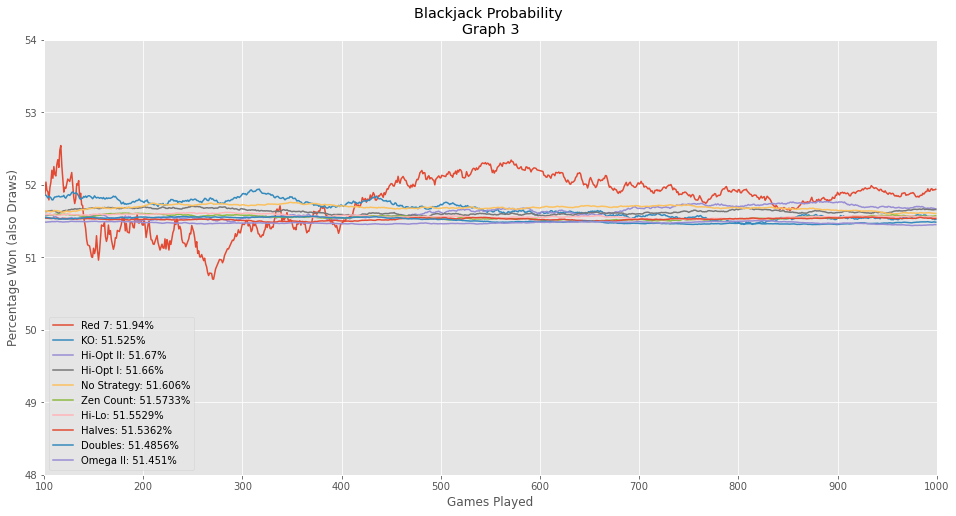

In [50]:
plt.style.use('ggplot')
plt.figure(figsize=(16,8))

# Plotting each strategies result
for i in results:
    plt.plot(games_sim, results[i], label=i+': '+str(results[i][-1])+'%')
    
plt.title("Blackjack Probability \nGraph 3")
plt.ylabel("Percentage Won (also Draws)")
plt.xlabel("Games Played")
plt.ylim([48,54])
plt.xlim([100,len(games_sim)])
plt.legend()
plt.savefig("bj_3.png")
plt.show()

## Conclusion

## Citations
- https://en.wikipedia.org/wiki/Blackjack
- https://rstudio-pubs-static.s3.amazonaws.com/279263_9c56825011694da8b1916ad1d604b41b.html
- https://towardsdatascience.com/python-blackjack-simulator-61b591ffb971
- 